### Домашнее задание №8 к лекции «Кейс-стади»

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# from sklearn.feature_extraction.text import TfidfVectorizer
import warnings # отключим предупреждения анаконды
warnings.filterwarnings('ignore')
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import TfidfModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)

### Задание 1
Вернемся к набору данных о видеоиграх.

Ответьте на следующие вопросы:  

1. Как критики относятся к спортивным играм?  
2. Критикам нравятся больше игры на PC или на PS4?  
3. Критикам больше нравятся стрелялки или стратегии?  

Для каждого вопроса:  

- сформулируйте нулевую и альтернативную гипотезы;  
- выберите пороговый уровень статистической значимости;  
- опишите полученные результаты статистического теста.  

In [2]:
games = pd.read_csv('https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/vgsales.csv')
display(games.head())

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


#### 1.1 Как критики относятся к спортивным играм?

Проверим выборки на нормальность и на количество наблюдений. Если они не нормальны и/не равны применим __U-тест__

In [4]:
games[~games['Critic_Score'].isna()]['Genre'].value_counts()

Action          1890
Sports          1194
Shooter          944
Racing           742
Role-Playing     737
Misc             523
Platform         497
Fighting         409
Simulation       352
Adventure        323
Strategy         302
Puzzle           224
Name: Genre, dtype: int64

In [5]:
x = games.loc[games['Genre'] == 'Sports']['Critic_Score'].dropna()
y = games.loc[games['Genre'] != 'Sports']['Critic_Score'].dropna()

Для sport p-значение 0.000% распределение не нормально
Для other p-значение 0.000% распределение не нормально


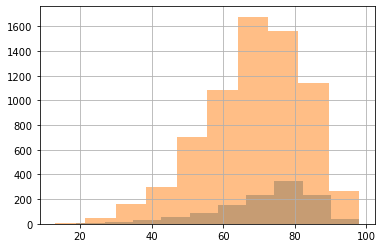

In [6]:
alpha = 0.05
for key,val in dict(zip(['sport', 'other'], [x, y])).items():
    results = stats.shapiro(val)
    p_value = results[1]
    if p_value < alpha:
        res = f'Для {key} p-значение {p_value:.3%} распределение не нормально'
    else:
        res = f'Для {key} p-значение {p_value:.3%} распределение нормально'
    print(res)
x.hist(alpha=.5)
y.hist(alpha=.5)
plt.show()

Выборки не нормальные, и разные по количеству. Применим непараметрический тест Манна-Уитни

In [7]:
alpha = 0.05
res = stats.mannwhitneyu(x, y)
print(f'альфа {alpha:.0%}')
print(f'Гипотеза об отношении критиков к спортивным играм и остальным\nH0 - различий нет\nH1 - различия есть')
print(f'p-значение:{res.pvalue:.20f}')
if (res.pvalue < alpha):
    print("Отклоняем нулевую гипотезу - различия есть")
else:
    print("Недостаточно оснований отклонить нулевую гипотезу")

альфа 5%
Гипотеза об отношении критиков к спортивным играм и остальным
H0 - различий нет
H1 - различия есть
p-значение:0.00000000000000000002
Отклоняем нулевую гипотезу - различия есть


Согласно __p-значения__, критики к спортивным играм относятся не так как к остальным, а судя по средней оценке, к спортивным играм они относятся лучше.

#### 1.2 Критикам нравятся больше игры на PC или на PS4?

Так же проверим выборки на нормальность и посмотрим на их средние

In [8]:
x = games.loc[games['Platform'] == 'PC']['Critic_Score'].dropna()
y = games.loc[games['Platform'] != 'PS4']['Critic_Score'].dropna()
x.mean(), y.mean()

(75.92867132867133, 68.86785034876347)

Для PC p-значение 0.000% распределение не нормально
Для PS4 p-значение 0.000% распределение не нормально


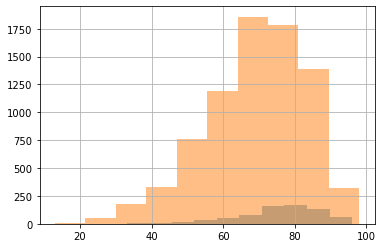

In [9]:
alpha = 0.05
for key,val in dict(zip(['PC', 'PS4'], [x, y])).items():
    results = stats.shapiro(val)
    p_value = results[1]
    if p_value < alpha:
        res = f'Для {key} p-значение {p_value:.3%} распределение не нормально'
    else:
        res = f'Для {key} p-значение {p_value:.3%} распределение нормально'
    print(res)
x.hist(alpha=.5)
y.hist(alpha=.5)
plt.show()

Как и ожидалось выборки не равны и не нормальны. Применим бутстрап.  
1. Будем случайно вынимать две группы равные группам А и Б, 
2. Вычислять разницу их средних,  
3. Сравнивать с реальной разницей,  
4. Если по модулю они превышают фактическую среднюю,  
5. Будем записывать этот факт в отдельный список  
Средняя этого списка будет __p-значением__

In [10]:
diff = abs(x.mean() - y.mean())
alpha = .05
boot = []
all_scores = pd.concat([x, y])
for i in range(10000):
    x_sample = all_scores.sample(len(x), replace=True)
    y_sample = all_scores.sample(len(y), replace=True)
    s = abs(x_sample.mean() - y_sample.mean()) >= diff
    boot.append(s)
p_value = pd.Series(boot).mean()
print(f'альфа {alpha:.0%}')
print('Гипотеза об отношении критиков к PC и PS4\nH0 - различий нет\nH1 - различия есть')
print(f'p-значение: {p_value:.20f}')
if (p_value < alpha):
    print("Отклоняем нулевую гипотезу - различия есть")
else:
    print("Недостаточно оснований отклонить нулевую гипотезу")

альфа 5%
Гипотеза об отношении критиков к PC и PS4
H0 - различий нет
H1 - различия есть
p-значение: 0.00000000000000000000
Отклоняем нулевую гипотезу - различия есть


Критикам больше нравятся игры на PC

#### 1.3 Критикам больше нравятся стрелялки или стратегии?

Аналогично проверим выборки на нормальность и равность. Если это не так (что скорее всего), преобразуем их бутстрапом. Будем с выдергивать все строки в случайном порядке, находить средние по стрелялкам или стратегиям и записывать их в отдельный список. Средние значения каждой подвыборки будут распределены нормально вокруг реальной средней согласно __ЦПТ__, таким образом мы приведем их к нормальному распределению и равными по количеству. Потом проверим гипотезу __t-тестом__

In [11]:
x = games.loc[games['Genre'] == 'Shooter']['Critic_Score'].dropna()
y = games.loc[games['Genre'] == 'Strategy']['Critic_Score'].dropna()

Для Shooter p-значение 0.000% распределение не нормально
Для Strategy p-значение 0.003% распределение не нормально


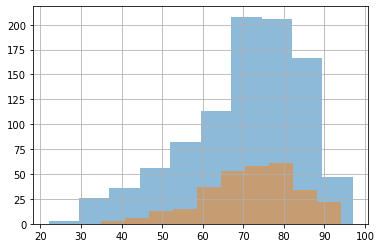

In [12]:
alpha = 0.05
for key,val in dict(zip(['Shooter', 'Strategy'], [x, y])).items():
    results = stats.shapiro(val)
    p_value = results[1]
    if p_value < alpha:
        res = f'Для {key} p-значение {p_value:.3%} распределение не нормально'
    else:
        res = f'Для {key} p-значение {p_value:.3%} распределение нормально'
    print(res)
x.hist(alpha=.5)
y.hist(alpha=.5)
plt.show()

<Figure size 1080x720 with 0 Axes>

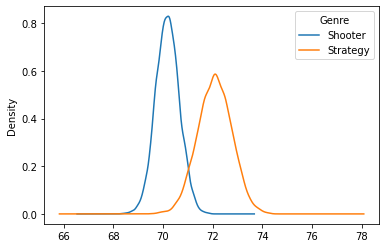

p-значение: 0.003%
Гипотеза об отношении критиков к стрелялкам и стратегиям
H0 - различий нет
H1 - различия есть
Отклоняем нулевую гипотезу - различия есть


In [13]:
plt.figure(figsize=(15, 10))
boot_1d = []
for i in range(10000):
    boot_mean = games[games['Genre'].isin(['Shooter', 'Strategy'])].sample(
        frac=1, replace=True).groupby('Genre')['Critic_Score'].mean()
    boot_1d.append(boot_mean)
boot_1d = pd.DataFrame(boot_1d)
boot_1d.plot(kind='density')
stats.ttest_ind(boot_1d['Shooter'], boot_1d['Strategy'], equal_var=False)
plt.show()

alpha = 0.05
print(f'p-значение: {(results.pvalue):.3%}')
print('Гипотеза об отношении критиков к стрелялкам и стратегиям\nH0 - различий нет\nH1 - различия есть')
if results.pvalue < alpha:
    print('Отклоняем нулевую гипотезу - различия есть')
else:
    print('Недостаточно оснований отклонить нулевую гипотезу')

Критикам больше нравятся стратегии

### Задание 2  
Реализуйте базовую модель логистической регрессии для классификации текстовых сообщений по признаку спама. Для этого:  

1. Привидите весь текст к нижнему регистру;
2. Удалите мусорные символы;
3. Удалите стоп-слова;
4. Привидите все слова к нормальной форме;
5. Преобразуйте все сообщения в вектора TF-IDF.
6. Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите random_state=42. Используйте train_test_split;
7. Постройте модель логистической регрессии, укажите random_state=42, оцените ее точность на тестовых данных;
8. Опишите результаты при помощи confusion_matrix;
9. Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного). 

In [14]:
spam = pd.read_csv('https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/spam.csv')
display(spam.sample(10))
display(spam.info())

,Category,Message
350,ham,Just checking in on you. Really do miss seeing...
459,ham,1.20 that call cost. Which i guess isnt bad. M...
5482,spam,URGENT We are trying to contact you Last weeke...
4156,spam,Want a new Video Phone? 750 anytime any networ...
5514,ham,Oh... Okie lor...We go on sat...
4598,ham,Full heat pa:-) i have applyed oil pa.
1125,ham,Aiyar sorry lor forgot 2 tell u...
4122,ham,Yunny... I'm goin to be late
1628,spam,You have been selected to stay in 1 of 250 top...
839,spam,We tried to contact you re our offer of New Vi...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


None

In [15]:
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/victorchudnovskiy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/victorchudnovskiy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Сразу же преобразуем значения __spam__ и __ham__ в __0__ и __1__

In [16]:
spam.loc[spam['Category'] == 'spam', 'Category'] = 0
spam.loc[spam['Category'] == 'ham', 'Category'] = 1

Напишем функцию преобразования текста:  
1. Оставим только символы входящие в состав слов
2. Только буквы англ алфавита.
3. Удалим цифры
4. Приведем все к начальной форме
5. Удалим слова состоящие из менее чем 2 букв
6. Преобразуем фразу в список отдельных слов

In [17]:
test = spam.loc[4768, 'Message']
test

'Your unique user ID is 1172. For removal send STOP to 87239 customer services 08708034412'

In [18]:
def spec_fun(row):
    stopwords_set = set(stopwords.words('english'))
    wordnet_lemmatizer = WordNetLemmatizer()
    res = row.lower()
    res = re.sub('[0-9]|[^a-zA-Z]|[\W_]+', ' ', res)
    res = res.split()
    res = [wordnet_lemmatizer.lemmatize(word) for word in res if word not in stopwords_set and len(word) > 2]
    return res

In [19]:
spec_fun(test)

['unique', 'user', 'removal', 'send', 'stop', 'customer', 'service']

In [20]:
spam['Message_proc'] = spam['Message'].apply(spec_fun)

In [21]:
spam

,Category,Message,Message_proc
0,1,"Go until jurong point, crazy.. Available only ...","[jurong, point, crazy, available, bugis, great..."
1,1,Ok lar... Joking wif u oni...,"[lar, joking, wif, oni]"
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, cup, final, tkt..."
3,1,U dun say so early hor... U c already then say...,"[dun, say, early, hor, already, say]"
4,1,"Nah I don't think he goes to usf, he lives aro...","[nah, think, go, usf, life, around, though]"
...,...,...,...
5567,0,This is the 2nd time we have tried 2 contact u...,"[time, tried, contact, pound, prize, claim, ea..."
5568,1,Will ü b going to esplanade fr home?,"[going, esplanade, home]"
5569,1,"Pity, * was in mood for that. So...any other s...","[pity, mood, suggestion]"
5570,1,The guy did some bitching but I acted like i'd...,"[guy, bitching, acted, like, interested, buyin..."


Составим словарь слов, после чего для каждого сообщения составим модель `TF-IDF`

In [22]:
dct = corpora.Dictionary(spam['Message_proc'])
print(dct)

Dictionary(6873 unique tokens: ['amore', 'available', 'buffet', 'bugis', 'cine']...)


In [23]:
spam['bows'] = spam['Message_proc'].apply(lambda x: dct.doc2bow(x))
model = TfidfModel(spam['bows'].to_list())
spam['tfidf'] = spam['bows'].apply(lambda x: model[x])

Преобразуем полученную таблицу в матрицу, где строками будут id сообщений а столбцами номера слов. На пересечении будут веса конкретных слов в конкретном сообщении. Эту матрицу и будем использовать в классификации

In [24]:
df = spam.explode('tfidf')
df[['word_id', 'word_coeff']] = pd.DataFrame(df['tfidf'].tolist(), index=df.index)
df.dropna(inplace=True)
df = df.astype({'word_id': 'int'})
df_matrix = df.reset_index().pivot_table(index=['index', 'Category'], columns='word_id', values='word_coeff', fill_value=0).reset_index()

In [25]:
df_matrix.head()

word_id,index,Category,0,1,2,3,4,5,6,7,...,6863,6864,6865,6866,6867,6868,6869,6870,6871,6872
0,0,1,0.400926,0.266577,0.368707,0.310477,0.310477,0.278259,0.148156,0.183294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обучим модель __Логистической регрессии__ на 30%

In [26]:
y = df_matrix['Category']
X = df_matrix.drop(['Category'], axis = 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression(random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)
model.fit(X_train_st, y_train)
y_pred = model.predict(X_test_st)
y_proba = model.predict_proba(X_test_st)[:, 1]

In [27]:
len(y_test), abs(y_test - y_pred).sum()

(1660, 47)

Если бегло, то модель ошиблась в 47 случаях из 1660
Проверим это метриками

In [28]:
metrics = {}
metrics['Accuracy'] = (accuracy_score(y_test, y_pred))
metrics['Precision'] = (precision_score(y_test, y_pred))
metrics['Recall'] = (recall_score(y_test, y_pred))
metrics['F1'] = (f1_score(y_test, y_pred))
metrics

{'Accuracy': 0.9716867469879518,
 'Precision': 0.9700272479564033,
 'Recall': 0.9978976874562018,
 'F1': 0.9837651122625215}

Все метрики показывают лучший результат приближаясь к __1__. Дополнительно оценим правильные и неправильные предсказания матрицей ошибок 
____
false positive + false negative в сумме должны дать 47

true negative = 189
false positive = 44
false negative = 3
true positive = 1424


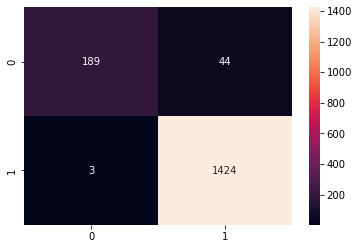

In [29]:
cm = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm.ravel()
print(f'true negative = {tn}\nfalse positive = {fp}\nfalse negative = {fn}\ntrue positive = {tp}')
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

Отберем неверно предсказанные категории 47-ми сообщений

In [30]:
X_test['cat'] = y_test
X_test['cat_pred'] = y_pred
df_test = X_test[['index', 'cat', 'cat_pred']].set_index('index')
df_test.loc[df_test['cat'] != df_test['cat_pred']].join(spam['Message'])

,cat,cat_pred,Message
index,,,
2770,0,1,Burger King - Wanna play footy at a top stadiu...
4953,0,1,"Welcome to Select, an O2 service with added be..."
3302,0,1,RCT' THNQ Adrian for U text. Rgds Vatian
5427,0,1,Santa Calling! Would your little ones like a c...
713,0,1,08714712388 between 10am-7pm Cost 10p
3864,0,1,Oh my god! I've found your number again! I'm s...
326,1,0,No calls..messages..missed calls
1893,0,1,CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
420,0,1,Send a logo 2 ur lover - 2 names joined by a h...
